We're going to train on dataset B2.

In [2]:
import torch
import skimage as ski
import numpy as np
from torch.utils.data import Dataset
import os
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import time
import matplotlib.pyplot as plt

# Data Loading

In [3]:
class PetDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_annotations)
    
    def __getitem__(self,idx):
        img_path = os.path.join(self.img_dir,self.img_annotations.iloc[idx,0])
        image = ski.io.imread(img_path)/255   
        image = image[:,:,:3] 
        class_label = self.img_annotations.iloc[idx,2]-1     
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            class_label = self.target_transform(class_label)     
        return image, class_label
    
size = 256
resize = T.Resize(size)
totensor = T.ToTensor()
trans = T.Compose([totensor,resize]) 

train = PetDataset('annotations_aug/annotations_train_B1.csv','img_augmented_processed/', transform = trans)
valid = PetDataset('annotations_aug/annotations_valid_B1.csv','img_augmented_processed/', transform = trans)
test = PetDataset('annotations_aug/annotations_test_B1.csv','img_augmented_processed/', transform = trans)

train_loader = DataLoader(train,batch_size=64,shuffle=True)
valid_loader = DataLoader(valid,batch_size=len(valid),shuffle=True)
test_loader = DataLoader(test,batch_size=len(test),shuffle=True)

shape of training batch (images): torch.Size([64, 3, 256, 256])
shape of training batch (labels): torch.Size([64])


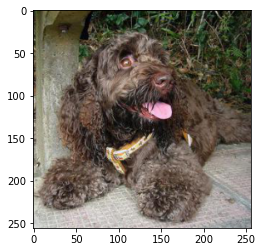

In [4]:
train_b1_img, train_b1_label = next(iter(train_loader))
print('shape of training batch (images): {}'.format(train_b1_img.shape))
print('shape of training batch (labels): {}'.format(train_b1_label.shape))
plt.imshow(train_b1_img[np.random.randint(64)].permute(1,2,0))     #plt.imshow needs the shape to be (x,y,3)
plt.show()

# Model with 6 conv layers, weak reg, lr decay

In [4]:
class PetCNN6(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( #nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( #nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.1),
                                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=256, out_channels=370, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.2),
                                    nn.Linear(int(370*((size-224)/32)*((size-224)/32)), 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model1 = PetCNN6()
loss_function = nn.NLLLoss()


print(model1)


    


PetCNN6(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout2d(p=0.1, inplace=False)
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=3, stride=2, pa

In [5]:
learning_rate = 0.001
decay_rate = 0.0003
lr_decay = 0.9    # we'll go for a learning rate decay by a factor of 0.9 every 3 epochs

optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=lr_decay)

num_epochs = 250

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            print('Current learning rate:{}'.format(optimizer.param_groups[0]['lr']))    # to print the current learning rate that is decaying every 5 epochs
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                
                model1.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
            
    scheduler.step()
                

            
        


Epoch:0
Iteration:50
Time taken for the last 50 iterations: 79.41143608093262
Current learning rate:0.001
Epoch:0
Iteration:100
Time taken for the last 50 iterations: 69.7626473903656
Current learning rate:0.001
Epoch:0
Iteration:150
Time taken for the last 50 iterations: 55.80986499786377
Current learning rate:0.001
Epoch:0
Iteration:200
Time taken for the last 50 iterations: 57.806447982788086
Current learning rate:0.001
Epoch:0
Iteration:250
Time taken for the last 50 iterations: 58.43844795227051
Current learning rate:0.001
Epoch:1
Iteration:300
Time taken for the last 50 iterations: 58.25927424430847
Current learning rate:0.001
Current training loss:2.9887499809265137
Current training accuracy:0.173828125
Current validation loss:2.812857151031494
Current validation accuracy:0.2264995574951172
Epoch:1
Iteration:350
Time taken for the last 50 iterations: 53.312320947647095
Current learning rate:0.001
Current training loss:2.910912275314331
Current training accuracy:0.1982421875
Curr

Current validation loss:2.829523801803589
Current validation accuracy:0.22470904886722565
Epoch:6
Iteration:1650
Time taken for the last 50 iterations: 55.73493838310242
Current learning rate:0.0008100000000000001
Current training loss:2.3402316570281982
Current training accuracy:0.353515625
Current validation loss:2.344630718231201
Current validation accuracy:0.33124440908432007
Epoch:6
Iteration:1700
Time taken for the last 50 iterations: 57.09509229660034
Current learning rate:0.0008100000000000001
Current training loss:2.1737821102142334
Current training accuracy:0.40087890625
Current validation loss:2.134324312210083
Current validation accuracy:0.39391225576400757
Epoch:6
Iteration:1750
Time taken for the last 50 iterations: 55.296027421951294
Current learning rate:0.0008100000000000001
Current training loss:2.3751213550567627
Current training accuracy:0.32470703125
Current validation loss:2.471299409866333
Current validation accuracy:0.31065353751182556
Epoch:6
Iteration:1800
Tim

Current training loss:1.2668757438659668
Current training accuracy:0.65771484375
Current validation loss:1.732656478881836
Current validation accuracy:0.49865710735321045
Epoch:11
Iteration:3100
Time taken for the last 50 iterations: 58.168816328048706
Current learning rate:0.000729
Current training loss:1.3271137475967407
Current training accuracy:0.64990234375
Current validation loss:1.855449914932251
Current validation accuracy:0.46553269028663635
Epoch:12
Iteration:3150
Time taken for the last 50 iterations: 55.392632246017456
Current learning rate:0.0006561000000000001
Current training loss:1.3022738695144653
Current training accuracy:0.63623046875
Current validation loss:1.8742083311080933
Current validation accuracy:0.4503133296966553
Epoch:12
Iteration:3200
Time taken for the last 50 iterations: 57.74479103088379
Current learning rate:0.0006561000000000001
Current training loss:1.1131221055984497
Current training accuracy:0.73095703125
Current validation loss:1.7426486015319824

Current validation loss:2.6697158813476562
Current validation accuracy:0.34019696712493896
Epoch:17
Iteration:4500
Time taken for the last 50 iterations: 58.84864044189453
Current learning rate:0.00059049
Current training loss:1.1581677198410034
Current training accuracy:0.70947265625
Current validation loss:1.8227883577346802
Current validation accuracy:0.46553269028663635
Epoch:17
Iteration:4550
Time taken for the last 50 iterations: 57.54804468154907
Current learning rate:0.00059049
Current training loss:0.9415544867515564
Current training accuracy:0.77978515625
Current validation loss:1.7570345401763916
Current validation accuracy:0.49507609009742737
Epoch:17
Iteration:4600
Time taken for the last 50 iterations: 58.52489233016968
Current learning rate:0.00059049
Current training loss:0.8801034688949585
Current training accuracy:0.80615234375
Current validation loss:1.7391873598098755
Current validation accuracy:0.5040286779403687
Epoch:17
Iteration:4650
Time taken for the last 50 i

Current training loss:0.45577943325042725
Current training accuracy:0.92138671875
Current validation loss:1.7244987487792969
Current validation accuracy:0.5174574851989746
Epoch:22
Iteration:5950
Time taken for the last 50 iterations: 58.28915452957153
Current learning rate:0.0004782969
Current training loss:0.43389075994491577
Current training accuracy:0.9228515625
Current validation loss:1.7297574281692505
Current validation accuracy:0.522828996181488
Epoch:22
Iteration:6000
Time taken for the last 50 iterations: 56.87056112289429
Current learning rate:0.0004782969
Current training loss:0.4189290702342987
Current training accuracy:0.92822265625
Current validation loss:1.7646766901016235
Current validation accuracy:0.5031334161758423
Epoch:23
Iteration:6050
Time taken for the last 50 iterations: 55.61717867851257
Current learning rate:0.0004782969
Current training loss:0.4309096932411194
Current training accuracy:0.93212890625
Current validation loss:1.792590618133545
Current validati

Epoch:28
Iteration:7350
Time taken for the last 50 iterations: 57.29508376121521
Current learning rate:0.000387420489
Current training loss:0.4673764705657959
Current training accuracy:0.892578125
Current validation loss:2.140638828277588
Current validation accuracy:0.4762757420539856
Epoch:28
Iteration:7400
Time taken for the last 50 iterations: 58.07300281524658
Current learning rate:0.000387420489
Current training loss:0.34674543142318726
Current training accuracy:0.94189453125
Current validation loss:1.8724355697631836
Current validation accuracy:0.49776187539100647
Epoch:28
Iteration:7450
Time taken for the last 50 iterations: 55.97282671928406
Current learning rate:0.000387420489
Current training loss:0.3173563480377197
Current training accuracy:0.95703125
Current validation loss:1.8371636867523193
Current validation accuracy:0.506714403629303
Epoch:28
Iteration:7500
Time taken for the last 50 iterations: 58.11770558357239
Current learning rate:0.000387420489
Current training los

Current training loss:0.16099460422992706
Current training accuracy:0.98193359375
Current validation loss:1.854796051979065
Current validation accuracy:0.5094001889228821
Epoch:33
Iteration:8800
Time taken for the last 50 iterations: 57.82822585105896
Current learning rate:0.00031381059609000004
Current training loss:0.1619405597448349
Current training accuracy:0.9814453125
Current validation loss:1.8240551948547363
Current validation accuracy:0.5192480087280273
Epoch:33
Iteration:8850
Time taken for the last 50 iterations: 58.62053346633911
Current learning rate:0.00031381059609000004
Current training loss:0.15172773599624634
Current training accuracy:0.98486328125
Current validation loss:1.855849266052246
Current validation accuracy:0.506714403629303
Epoch:34
Iteration:8900
Time taken for the last 50 iterations: 56.91767406463623
Current learning rate:0.00031381059609000004
Current training loss:0.32957908511161804
Current training accuracy:0.94482421875
Current validation loss:2.164

Epoch:38
Iteration:10150
Time taken for the last 50 iterations: 55.70791268348694
Current learning rate:0.00028242953648100003
Current training loss:0.13459423184394836
Current training accuracy:0.98291015625
Current validation loss:1.9776774644851685
Current validation accuracy:0.5058191418647766
Epoch:39
Iteration:10200
Time taken for the last 50 iterations: 57.04990339279175
Current learning rate:0.00025418658283290005
Current training loss:0.21890774369239807
Current training accuracy:0.97314453125
Current validation loss:2.095616340637207
Current validation accuracy:0.47806623578071594
Epoch:39
Iteration:10250
Time taken for the last 50 iterations: 58.09349608421326
Current learning rate:0.00025418658283290005
Current training loss:0.1656644344329834
Current training accuracy:0.98193359375
Current validation loss:1.9896416664123535
Current validation accuracy:0.5022381544113159
Epoch:39
Iteration:10300
Time taken for the last 50 iterations: 58.17296504974365
Current learning rate:

Current validation loss:2.316056966781616
Current validation accuracy:0.4261414408683777
Epoch:44
Iteration:11550
Time taken for the last 50 iterations: 57.469979763031006
Current learning rate:0.00022876792454961005
Current training loss:0.1188470795750618
Current training accuracy:0.98681640625
Current validation loss:2.0663845539093018
Current validation accuracy:0.48075202107429504
Epoch:44
Iteration:11600
Time taken for the last 50 iterations: 54.786338329315186
Current learning rate:0.00022876792454961005
Current training loss:0.1206369623541832
Current training accuracy:0.98828125
Current validation loss:2.0018153190612793
Current validation accuracy:0.49239033460617065
Epoch:44
Iteration:11650
Time taken for the last 50 iterations: 56.55872058868408
Current learning rate:0.00022876792454961005
Current training loss:0.10460108518600464
Current training accuracy:0.99365234375
Current validation loss:2.0010933876037598
Current validation accuracy:0.4914950728416443
Epoch:44
Iterat

Current training loss:0.08806785196065903
Current training accuracy:0.99365234375
Current validation loss:2.0240843296051025
Current validation accuracy:0.5219337344169617
Epoch:49
Iteration:12950
Time taken for the last 50 iterations: 58.2926561832428
Current learning rate:0.00018530201888518417
Current training loss:0.07564326375722885
Current training accuracy:0.9951171875
Current validation loss:2.036806583404541
Current validation accuracy:0.5138764381408691
Epoch:49
Iteration:13000
Time taken for the last 50 iterations: 58.027525663375854
Current learning rate:0.00018530201888518417
Current training loss:0.09001119434833527
Current training accuracy:0.99072265625
Current validation loss:2.0324676036834717
Current validation accuracy:0.5147716999053955
Epoch:49
Iteration:13050
Time taken for the last 50 iterations: 51.8794801235199
Current learning rate:0.00018530201888518417
Current training loss:0.09054525941610336
Current training accuracy:0.9921875
Current validation loss:2.08


KeyboardInterrupt



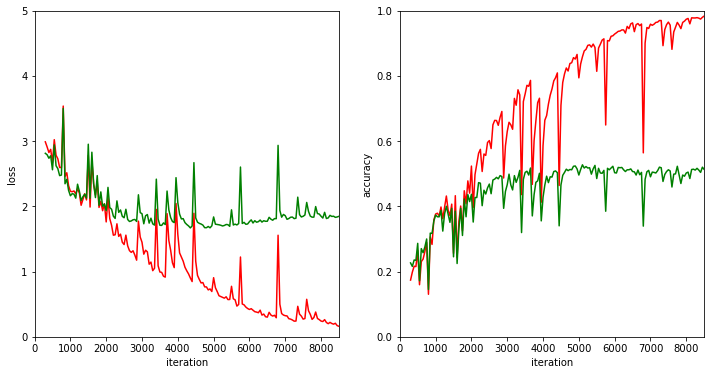

In [6]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,8500)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,8500)
acc_graph.set_ylim(0,1)

plt.show() 

# Same as above, stronger lr decay

We only need to train to the point that the validation accuracy is the max (and validation loss is at a minimum). This is around 52% with a loss of around 1.67-1.71. So we'll make the lr decay stronger to reach this with a smoother learning curve.

In [7]:
class PetCNN6(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( #nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( #nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.1),
                                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=256, out_channels=370, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.2),
                                    nn.Linear(int(370*((size-224)/32)*((size-224)/32)), 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model1 = PetCNN6()
loss_function = nn.NLLLoss()

learning_rate = 0.001
decay_rate = 0.0003
lr_decay = 0.7    # we'll go for a learning rate decay by a factor of 0.7 every 2 epochs

optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=lr_decay)

num_epochs = 120

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            print('Current learning rate:{}'.format(optimizer.param_groups[0]['lr']))    # to print the current learning rate that is decaying every 5 epochs
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                
                model1.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
            
    scheduler.step()
                

            
        


    


Epoch:0
Iteration:50
Time taken for the last 50 iterations: 29.53365707397461
Current learning rate:0.001
Epoch:0
Iteration:100
Time taken for the last 50 iterations: 53.45823359489441
Current learning rate:0.001
Epoch:0
Iteration:150
Time taken for the last 50 iterations: 64.61643767356873
Current learning rate:0.001
Epoch:0
Iteration:200
Time taken for the last 50 iterations: 65.5216600894928
Current learning rate:0.001
Epoch:0
Iteration:250
Time taken for the last 50 iterations: 63.17640042304993
Current learning rate:0.001
Epoch:1
Iteration:300
Time taken for the last 50 iterations: 57.52787661552429
Current learning rate:0.001
Current training loss:3.016247034072876
Current training accuracy:0.16455078125
Current validation loss:2.911693811416626
Current validation accuracy:0.18800358474254608
Epoch:1
Iteration:350
Time taken for the last 50 iterations: 53.63009858131409
Current learning rate:0.001
Current training loss:2.9916625022888184
Current training accuracy:0.1650390625
Cur

Current validation loss:1.9352518320083618
Current validation accuracy:0.43957027792930603
Epoch:6
Iteration:1700
Time taken for the last 50 iterations: 61.225040674209595
Current learning rate:0.000343
Current training loss:1.7133296728134155
Current training accuracy:0.53662109375
Current validation loss:1.893715500831604
Current validation accuracy:0.4583706259727478
Epoch:6
Iteration:1750
Time taken for the last 50 iterations: 59.30032992362976
Current learning rate:0.000343
Current training loss:1.7265043258666992
Current training accuracy:0.53173828125
Current validation loss:1.8963844776153564
Current validation accuracy:0.4485228359699249
Epoch:6
Iteration:1800
Time taken for the last 50 iterations: 59.82628011703491
Current learning rate:0.000343
Current training loss:1.7160509824752808
Current training accuracy:0.5361328125
Current validation loss:1.9239507913589478
Current validation accuracy:0.4341987371444702
Epoch:7
Iteration:1850
Time taken for the last 50 iterations: 60

Epoch:11
Iteration:3100
Time taken for the last 50 iterations: 65.5239028930664
Current learning rate:0.00016806999999999998
Current training loss:1.0894229412078857
Current training accuracy:0.744140625
Current validation loss:1.7290728092193604
Current validation accuracy:0.5049238801002502
Epoch:12
Iteration:3150
Time taken for the last 50 iterations: 58.40086007118225
Current learning rate:0.00011764899999999998
Current training loss:1.2002143859863281
Current training accuracy:0.7080078125
Current validation loss:1.7926113605499268
Current validation accuracy:0.4879140555858612
Epoch:12
Iteration:3200
Time taken for the last 50 iterations: 52.45299220085144
Current learning rate:0.00011764899999999998
Current training loss:1.0994137525558472
Current training accuracy:0.75048828125
Current validation loss:1.7279659509658813
Current validation accuracy:0.49507609009742737
Epoch:12
Iteration:3250
Time taken for the last 50 iterations: 59.061808347702026
Current learning rate:0.000117

Epoch:17
Iteration:4500
Time taken for the last 50 iterations: 60.40212845802307
Current learning rate:5.764800999999999e-05
Current training loss:0.8092629313468933
Current training accuracy:0.84619140625
Current validation loss:1.7183856964111328
Current validation accuracy:0.5111907124519348
Epoch:17
Iteration:4550
Time taken for the last 50 iterations: 62.727901220321655
Current learning rate:5.764800999999999e-05
Current training loss:0.7805894613265991
Current training accuracy:0.85546875
Current validation loss:1.7199207544326782
Current validation accuracy:0.5174574851989746
Epoch:17
Iteration:4600
Time taken for the last 50 iterations: 61.98631763458252
Current learning rate:5.764800999999999e-05
Current training loss:0.788547933101654
Current training accuracy:0.85693359375
Current validation loss:1.713505506515503
Current validation accuracy:0.5111907124519348
Epoch:17
Iteration:4650
Time taken for the last 50 iterations: 60.67426800727844
Current learning rate:5.76480099999

Epoch:22
Iteration:5900
Time taken for the last 50 iterations: 60.56711411476135
Current learning rate:1.9773267429999995e-05
Current training loss:0.7220631837844849
Current training accuracy:0.87109375
Current validation loss:1.7222390174865723
Current validation accuracy:0.5192480087280273
Epoch:22
Iteration:5950
Time taken for the last 50 iterations: 58.36935758590698
Current learning rate:1.9773267429999995e-05
Current training loss:0.7521619200706482
Current training accuracy:0.85791015625
Current validation loss:1.7201052904129028
Current validation accuracy:0.5111907124519348
Epoch:22
Iteration:6000
Time taken for the last 50 iterations: 59.643847942352295
Current learning rate:1.9773267429999995e-05
Current training loss:0.7207667827606201
Current training accuracy:0.8701171875
Current validation loss:1.7152001857757568
Current validation accuracy:0.5102954506874084
Epoch:23
Iteration:6050
Time taken for the last 50 iterations: 57.655826568603516
Current learning rate:1.977326

Current validation loss:1.7185940742492676
Current validation accuracy:0.5138764381408691
Epoch:27
Iteration:7300
Time taken for the last 50 iterations: 37.29405951499939
Current learning rate:9.688901040699997e-06
Current training loss:0.6737029552459717
Current training accuracy:0.8828125
Current validation loss:1.720841884613037
Current validation accuracy:0.5120859742164612
Epoch:28
Iteration:7350
Time taken for the last 50 iterations: 35.4816734790802
Current learning rate:6.782230728489997e-06
Current training loss:0.6891364455223083
Current training accuracy:0.87841796875
Current validation loss:1.7239530086517334
Current validation accuracy:0.5102954506874084


KeyboardInterrupt: 

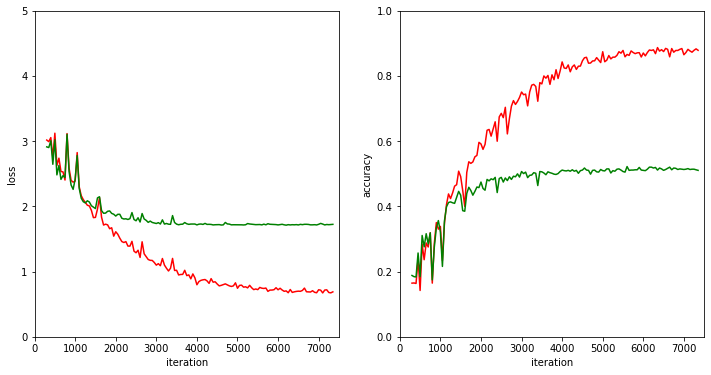

In [8]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,7500)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,7500)
acc_graph.set_ylim(0,1)

plt.show() 

Need to reduce the lr decay on this one coz training is saturating around 87%

# Same as above, slightly weaker lr decay

In [12]:
class PetCNN6(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( #nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( #nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.1),
                                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=256, out_channels=370, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.2),
                                    nn.Linear(int(370*((size-224)/32)*((size-224)/32)), 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model1 = PetCNN6()
loss_function = nn.NLLLoss()

learning_rate = 0.001
decay_rate = 0.0003
lr_decay = 0.75    # we'll go for a learning rate decay by a factor of 0.75 every 2 epochs

optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=lr_decay)

num_epochs = 60

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            print('Current learning rate:{}'.format(optimizer.param_groups[0]['lr']))    # to print the current learning rate that is decaying every 5 epochs
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                
                model1.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
            
    scheduler.step()
                

            
        


    


Epoch:0
Iteration:50
Time taken for the last 50 iterations: 34.67726159095764
Current learning rate:0.001
Epoch:0
Iteration:100
Time taken for the last 50 iterations: 37.849393129348755
Current learning rate:0.001
Epoch:0
Iteration:150
Time taken for the last 50 iterations: 40.49923610687256
Current learning rate:0.001
Epoch:0
Iteration:200
Time taken for the last 50 iterations: 49.54066205024719
Current learning rate:0.001
Epoch:0
Iteration:250
Time taken for the last 50 iterations: 39.24721956253052
Current learning rate:0.001
Epoch:1
Iteration:300
Time taken for the last 50 iterations: 38.911471128463745
Current learning rate:0.001
Current training loss:3.0890729427337646
Current training accuracy:0.17626953125
Current validation loss:3.027637481689453
Current validation accuracy:0.17994628846645355
Epoch:1
Iteration:350
Time taken for the last 50 iterations: 39.58435606956482
Current learning rate:0.001
Current training loss:3.176307201385498
Current training accuracy:0.14990234375

Epoch:6
Iteration:1650
Time taken for the last 50 iterations: 35.37688183784485
Current learning rate:0.00042187500000000005
Current training loss:1.625014305114746
Current training accuracy:0.5517578125
Current validation loss:1.7927820682525635
Current validation accuracy:0.46463742852211
Epoch:6
Iteration:1700
Time taken for the last 50 iterations: 35.59614849090576
Current learning rate:0.00042187500000000005
Current training loss:1.6122628450393677
Current training accuracy:0.56201171875
Current validation loss:1.7919726371765137
Current validation accuracy:0.4798567593097687
Epoch:6
Iteration:1750
Time taken for the last 50 iterations: 35.452221632003784
Current learning rate:0.00042187500000000005
Current training loss:1.6305806636810303
Current training accuracy:0.55078125
Current validation loss:1.7510780096054077
Current validation accuracy:0.4879140555858612
Epoch:6
Iteration:1800
Time taken for the last 50 iterations: 35.51097059249878
Current learning rate:0.00042187500000

Epoch:11
Iteration:3050
Time taken for the last 50 iterations: 35.6334912776947
Current learning rate:0.00023730468750000005
Current training loss:0.9833714365959167
Current training accuracy:0.763671875
Current validation loss:1.6018977165222168
Current validation accuracy:0.5299910306930542
Epoch:11
Iteration:3100
Time taken for the last 50 iterations: 35.522202014923096
Current learning rate:0.00023730468750000005
Current training loss:0.9637052416801453
Current training accuracy:0.7783203125
Current validation loss:1.6084648370742798
Current validation accuracy:0.5264100432395935
Epoch:12
Iteration:3150
Time taken for the last 50 iterations: 34.77657461166382
Current learning rate:0.00017797851562500002
Current training loss:1.0736992359161377
Current training accuracy:0.73095703125
Current validation loss:1.697830319404602
Current validation accuracy:0.49239033460617065
Epoch:12
Iteration:3200
Time taken for the last 50 iterations: 35.69330358505249
Current learning rate:0.0001779

Current validation loss:1.5845481157302856
Current validation accuracy:0.534467339515686
Epoch:17
Iteration:4450
Time taken for the last 50 iterations: 35.00216817855835
Current learning rate:0.00010011291503906251
Current training loss:0.6439893841743469
Current training accuracy:0.89208984375
Current validation loss:1.568504810333252
Current validation accuracy:0.5443151593208313
Epoch:17
Iteration:4500
Time taken for the last 50 iterations: 35.55016303062439
Current learning rate:0.00010011291503906251
Current training loss:0.6258711218833923
Current training accuracy:0.88427734375
Current validation loss:1.5638136863708496
Current validation accuracy:0.5425246357917786
Epoch:17
Iteration:4550
Time taken for the last 50 iterations: 35.529598236083984
Current learning rate:0.00010011291503906251
Current training loss:0.620525062084198
Current training accuracy:0.8837890625
Current validation loss:1.566992163658142
Current validation accuracy:0.5425246357917786
Epoch:17
Iteration:4600

Current validation loss:1.5683616399765015
Current validation accuracy:0.5416293740272522
Epoch:22
Iteration:5850
Time taken for the last 50 iterations: 35.478538274765015
Current learning rate:4.22351360321045e-05
Current training loss:0.47724124789237976
Current training accuracy:0.93115234375
Current validation loss:1.5742161273956299
Current validation accuracy:0.5425246357917786
Epoch:22
Iteration:5900
Time taken for the last 50 iterations: 35.62174439430237
Current learning rate:4.22351360321045e-05
Current training loss:0.4912939965724945
Current training accuracy:0.92822265625
Current validation loss:1.5682861804962158
Current validation accuracy:0.5416293740272522
Epoch:22
Iteration:5950
Time taken for the last 50 iterations: 35.76206564903259
Current learning rate:4.22351360321045e-05
Current training loss:0.47009286284446716
Current training accuracy:0.93603515625
Current validation loss:1.5798598527908325
Current validation accuracy:0.5353626012802124
Epoch:22
Iteration:600

Current training loss:0.4583343267440796
Current training accuracy:0.9287109375
Current validation loss:1.5720438957214355
Current validation accuracy:0.5407341122627258
Epoch:27
Iteration:7250
Time taken for the last 50 iterations: 35.630362033843994
Current learning rate:2.3757264018058778e-05
Current training loss:0.44302257895469666
Current training accuracy:0.93017578125
Current validation loss:1.5699442625045776
Current validation accuracy:0.5380483269691467
Epoch:27
Iteration:7300
Time taken for the last 50 iterations: 35.44566059112549
Current learning rate:2.3757264018058778e-05
Current training loss:0.4349646270275116
Current training accuracy:0.9375
Current validation loss:1.5689822435379028
Current validation accuracy:0.5416293740272522
Epoch:28
Iteration:7350
Time taken for the last 50 iterations: 34.960694551467896
Current learning rate:1.7817948013544083e-05
Current training loss:0.45211076736450195
Current training accuracy:0.93408203125
Current validation loss:1.569033

Current training loss:0.416275292634964
Current training accuracy:0.93798828125
Current validation loss:1.5693864822387695
Current validation accuracy:0.5398388504981995
Epoch:33
Iteration:8650
Time taken for the last 50 iterations: 34.91039514541626
Current learning rate:1.0022595757618546e-05
Current training loss:0.4129738509654999
Current training accuracy:0.9453125
Current validation loss:1.571363091468811
Current validation accuracy:0.5434198975563049
Epoch:33
Iteration:8700
Time taken for the last 50 iterations: 35.6239070892334
Current learning rate:1.0022595757618546e-05
Current training loss:0.40066471695899963
Current training accuracy:0.95068359375
Current validation loss:1.5684360265731812
Current validation accuracy:0.5407341122627258
Epoch:33
Iteration:8750
Time taken for the last 50 iterations: 35.45317029953003
Current learning rate:1.0022595757618546e-05
Current training loss:0.4069724977016449
Current training accuracy:0.9404296875
Current validation loss:1.575616717

Current training loss:0.3937438428401947
Current training accuracy:0.94775390625
Current validation loss:1.5691237449645996
Current validation accuracy:0.5389435887336731
Epoch:38
Iteration:10050
Time taken for the last 50 iterations: 35.63321089744568
Current learning rate:4.228282585245324e-06
Current training loss:0.3761723041534424
Current training accuracy:0.9462890625
Current validation loss:1.5681369304656982
Current validation accuracy:0.5398388504981995
Epoch:38
Iteration:10100
Time taken for the last 50 iterations: 35.578070640563965
Current learning rate:4.228282585245324e-06
Current training loss:0.40626266598701477
Current training accuracy:0.9443359375
Current validation loss:1.568668007850647
Current validation accuracy:0.5398388504981995
Epoch:38
Iteration:10150
Time taken for the last 50 iterations: 35.652732372283936
Current learning rate:4.228282585245324e-06
Current training loss:0.39976105093955994
Current training accuracy:0.94580078125
Current validation loss:1.5

Current training loss:0.41548654437065125
Current training accuracy:0.9423828125
Current validation loss:1.5695407390594482
Current validation accuracy:0.5407341122627258
Epoch:43
Iteration:11450
Time taken for the last 50 iterations: 35.551976442337036
Current learning rate:2.3784089542004944e-06
Current training loss:0.3887527585029602
Current training accuracy:0.9423828125
Current validation loss:1.5744143724441528
Current validation accuracy:0.5434198975563049
Epoch:44
Iteration:11500
Time taken for the last 50 iterations: 34.969327211380005
Current learning rate:1.7838067156503708e-06
Current training loss:0.3904901146888733
Current training accuracy:0.9443359375
Current validation loss:1.583999514579773
Current validation accuracy:0.5425246357917786
Epoch:44
Iteration:11550
Time taken for the last 50 iterations: 35.61143898963928
Current learning rate:1.7838067156503708e-06
Current training loss:0.40646523237228394
Current training accuracy:0.9384765625
Current validation loss:1.

Current training loss:0.4137948155403137
Current training accuracy:0.9462890625
Current validation loss:1.5783400535583496
Current validation accuracy:0.5353626012802124
Epoch:49
Iteration:12850
Time taken for the last 50 iterations: 35.64532685279846
Current learning rate:1.0033912775533336e-06
Current training loss:0.3917253613471985
Current training accuracy:0.94482421875
Current validation loss:1.5713911056518555
Current validation accuracy:0.5434198975563049
Epoch:49
Iteration:12900
Time taken for the last 50 iterations: 35.66707730293274
Current learning rate:1.0033912775533336e-06
Current training loss:0.39695772528648376
Current training accuracy:0.94677734375
Current validation loss:1.568601131439209
Current validation accuracy:0.5452103614807129
Epoch:49
Iteration:12950
Time taken for the last 50 iterations: 35.517908573150635
Current learning rate:1.0033912775533336e-06
Current training loss:0.42997223138809204
Current training accuracy:0.93994140625
Current validation loss:

Current training loss:0.4061591327190399
Current training accuracy:0.9453125
Current validation loss:1.564496636390686
Current validation accuracy:0.5416293740272522
Epoch:54
Iteration:14250
Time taken for the last 50 iterations: 35.58630895614624
Current learning rate:4.233056952178126e-07
Current training loss:0.3873165547847748
Current training accuracy:0.9462890625
Current validation loss:1.5690622329711914
Current validation accuracy:0.5434198975563049
Epoch:54
Iteration:14300
Time taken for the last 50 iterations: 35.672449350357056
Current learning rate:4.233056952178126e-07
Current training loss:0.4085877239704132
Current training accuracy:0.94189453125
Current validation loss:1.5745540857315063
Current validation accuracy:0.5389435887336731
Epoch:54
Iteration:14350
Time taken for the last 50 iterations: 35.67210602760315
Current learning rate:4.233056952178126e-07
Current training loss:0.3869485557079315
Current training accuracy:0.94970703125
Current validation loss:1.5726622

Current training loss:0.4093920886516571
Current training accuracy:0.94384765625
Current validation loss:1.5713120698928833
Current validation accuracy:0.5407341122627258
Epoch:59
Iteration:15650
Time taken for the last 50 iterations: 35.59742474555969
Current learning rate:2.3810945356001957e-07
Current training loss:0.39150890707969666
Current training accuracy:0.9423828125
Current validation loss:1.564182162284851
Current validation accuracy:0.5398388504981995


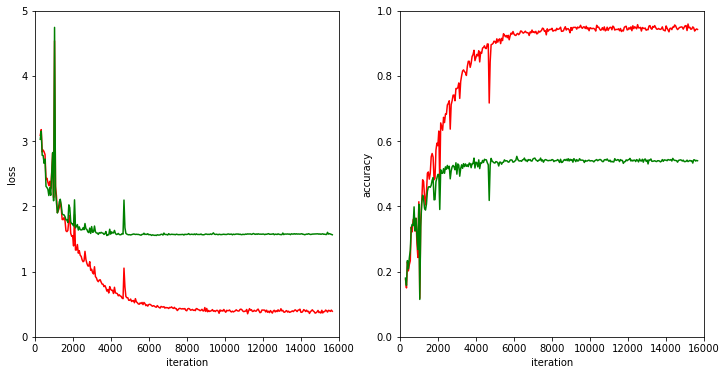

In [14]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,16000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,16000)
acc_graph.set_ylim(0,1)

plt.show() 

# Same as above, slightly weaker lr decay

In [ ]:
class PetCNN6(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( #nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( #nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.1),
                                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=256, out_channels=370, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.2),
                                    nn.Linear(int(370*((size-224)/32)*((size-224)/32)), 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model1 = PetCNN6()
loss_function = nn.NLLLoss()

learning_rate = 0.001
decay_rate = 0.0003
lr_decay = 0.76    # we'll go for a learning rate decay by a factor of 0.775 every 2 epochs

optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=lr_decay)

num_epochs = 70

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            print('Current learning rate:{}'.format(optimizer.param_groups[0]['lr']))    # to print the current learning rate that is decaying every 5 epochs
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                
                model1.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
            
    scheduler.step()
                

            
        


    


Epoch:0
Iteration:50
Time taken for the last 50 iterations: 31.94088387489319
Current learning rate:0.001
Epoch:0
Iteration:100
Time taken for the last 50 iterations: 38.31597876548767
Current learning rate:0.001
Epoch:0
Iteration:150
Time taken for the last 50 iterations: 39.39856576919556
Current learning rate:0.001
Epoch:0
Iteration:200
Time taken for the last 50 iterations: 38.99557065963745
Current learning rate:0.001
Epoch:0
Iteration:250
Time taken for the last 50 iterations: 39.19057822227478
Current learning rate:0.001
Epoch:1
Iteration:300
Time taken for the last 50 iterations: 37.78547263145447
Current learning rate:0.001
Current training loss:3.2098934650421143
Current training accuracy:0.13037109375
Current validation loss:3.1791439056396484
Current validation accuracy:0.13876454532146454
Epoch:1
Iteration:350
Time taken for the last 50 iterations: 37.65985465049744
Current learning rate:0.001
Current training loss:2.8770101070404053
Current training accuracy:0.2197265625


Current training loss:1.7895829677581787
Current training accuracy:0.50537109375
Current validation loss:1.941490888595581
Current validation accuracy:0.4404655396938324
Epoch:6
Iteration:1700
Time taken for the last 50 iterations: 38.28150963783264
Current learning rate:0.00043897600000000005
Current training loss:1.7899178266525269
Current training accuracy:0.50048828125
Current validation loss:1.9230176210403442
Current validation accuracy:0.44762757420539856
Epoch:6
Iteration:1750
Time taken for the last 50 iterations: 37.929060220718384
Current learning rate:0.00043897600000000005
Current training loss:1.744810938835144
Current training accuracy:0.52978515625
Current validation loss:1.8771369457244873
Current validation accuracy:0.44494181871414185
Epoch:6
Iteration:1800
Time taken for the last 50 iterations: 38.254207372665405
Current learning rate:0.00043897600000000005
Current training loss:1.6525970697402954
Current training accuracy:0.5595703125
Current validation loss:1.8758

Current training loss:1.1824709177017212
Current training accuracy:0.71044921875
Current validation loss:1.7290072441101074
Current validation accuracy:0.48970457911491394
Epoch:11
Iteration:3100
Time taken for the last 50 iterations: 40.106379985809326
Current learning rate:0.00025355253760000004
Current training loss:1.20374596118927
Current training accuracy:0.71728515625
Current validation loss:1.7249057292938232
Current validation accuracy:0.48970457911491394
Epoch:12
Iteration:3150
Time taken for the last 50 iterations: 40.27140474319458
Current learning rate:0.00019269992857600003
Current training loss:1.3047659397125244
Current training accuracy:0.6640625
Current validation loss:1.817359447479248
Current validation accuracy:0.48343777656555176
Epoch:12
Iteration:3200
Time taken for the last 50 iterations: 40.62111830711365
Current learning rate:0.00019269992857600003
Current training loss:1.1869007349014282
Current training accuracy:0.7236328125
Current validation loss:1.717982

Current training loss:0.8866430521011353
Current training accuracy:0.81884765625
Current validation loss:1.7127403020858765
Current validation accuracy:0.5192480087280273
Epoch:17
Iteration:4500
Time taken for the last 50 iterations: 35.24594235420227
Current learning rate:0.0001113034787454976
Current training loss:0.8016971945762634
Current training accuracy:0.8515625
Current validation loss:1.6895177364349365
Current validation accuracy:0.5246195197105408
Epoch:17
Iteration:4550
Time taken for the last 50 iterations: 35.2124764919281
Current learning rate:0.0001113034787454976
Current training loss:0.8099534511566162
Current training accuracy:0.8359375
Current validation loss:1.6783533096313477
Current validation accuracy:0.5210384726524353
Epoch:17
Iteration:4600
Time taken for the last 50 iterations: 35.344862937927246
Current learning rate:0.0001113034787454976
Current training loss:0.7658436298370361
Current training accuracy:0.849609375
Current validation loss:1.692718744277954

Current training loss:0.629177451133728
Current training accuracy:0.896484375
Current validation loss:1.679609775543213
Current validation accuracy:0.5273053050041199
Epoch:22
Iteration:5900
Time taken for the last 50 iterations: 35.41656756401062
Current learning rate:4.885955588578356e-05
Current training loss:0.6780756711959839
Current training accuracy:0.8876953125
Current validation loss:1.6819891929626465
Current validation accuracy:0.5246195197105408
Epoch:22
Iteration:5950
Time taken for the last 50 iterations: 35.167192220687866
Current learning rate:4.885955588578356e-05
Current training loss:0.6385049819946289
Current training accuracy:0.890625
Current validation loss:1.6610586643218994
Current validation accuracy:0.5326768159866333
Epoch:22
Iteration:6000
Time taken for the last 50 iterations: 35.442445278167725
Current learning rate:4.885955588578356e-05
Current training loss:0.6445630788803101
Current training accuracy:0.8994140625
Current validation loss:1.67568814754486

Current training loss:0.55634605884552
Current training accuracy:0.91650390625
Current validation loss:1.6712028980255127
Current validation accuracy:0.5317815542221069
Epoch:27
Iteration:7300
Time taken for the last 50 iterations: 35.87548232078552
Current learning rate:2.8221279479628584e-05
Current training loss:0.5657789707183838
Current training accuracy:0.90869140625
Current validation loss:1.6695563793182373
Current validation accuracy:0.5282005667686462
Epoch:28
Iteration:7350
Time taken for the last 50 iterations: 34.71830081939697
Current learning rate:2.1448172404517724e-05
Current training loss:0.5626159310340881
Current training accuracy:0.90673828125
Current validation loss:1.6746180057525635
Current validation accuracy:0.5299910306930542
Epoch:28
Iteration:7400
Time taken for the last 50 iterations: 35.26632022857666
Current learning rate:2.1448172404517724e-05
Current training loss:0.5554606318473816
Current training accuracy:0.91845703125
Current validation loss:1.6755

# Model with 5 conv layers

In [9]:
class PetCNN5(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2),
                                    nn.MaxPool2d(kernel_size=4,stride=2),
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( nn.Dropout2d(0.1),
                                    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(32),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( nn.Dropout2d(0.1),
                                    nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, stride=2),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.1),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=256, out_channels=370, kernel_size=2, stride=1),                                    
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.2),
                                    nn.Linear(370, 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    

loss_function = nn.NLLLoss()


model1 = PetCNN5()
print(model1)



PetCNN5(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Dropout2d(p=0.1, inplace=False)
    (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv3): Sequential(
    (0): Dropout2d(p=0.1, inplace=False)
    (1): Conv2d(32, 128, kernel_size=(3, 3), stride=(2, 2))
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout2d(p=0.1, inplace=False)
    (1): Conv2d(128

In [10]:
learning_rate = 0.001
decay_rate = 0.0002
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 150

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                

            
        


Epoch:0
Iteration:50
Time taken for the last 50 iterations: 22.14400601387024
Epoch:0
Iteration:100
Time taken for the last 50 iterations: 20.533162355422974
Epoch:0
Iteration:150
Time taken for the last 50 iterations: 20.307546138763428
Epoch:0
Iteration:200
Time taken for the last 50 iterations: 18.545879364013672
Epoch:0
Iteration:250
Time taken for the last 50 iterations: 20.726471662521362
Epoch:1
Iteration:300
Time taken for the last 50 iterations: 20.583892107009888
Current training loss:3.277782917022705
Current training accuracy:0.10400390625
Current validation loss:3.229033946990967
Current validation accuracy:0.10474485158920288
Epoch:1
Iteration:350
Time taken for the last 50 iterations: 20.382413387298584
Current training loss:3.180346727371216
Current training accuracy:0.1328125
Current validation loss:3.0905709266662598
Current validation accuracy:0.15040285885334015
Epoch:1
Iteration:400
Time taken for the last 50 iterations: 21.59339141845703
Current training loss:3.16

Current training loss:2.9469962120056152
Current training accuracy:0.1865234375
Current validation loss:2.864966869354248
Current validation accuracy:0.19427037239074707
Epoch:7
Iteration:1900
Time taken for the last 50 iterations: 19.132566928863525
Current training loss:2.865708827972412
Current training accuracy:0.205078125
Current validation loss:2.7177975177764893
Current validation accuracy:0.23455685377120972
Epoch:7
Iteration:1950
Time taken for the last 50 iterations: 18.775220155715942
Current training loss:2.7810258865356445
Current training accuracy:0.2255859375
Current validation loss:2.6928446292877197
Current validation accuracy:0.23724260926246643
Epoch:7
Iteration:2000
Time taken for the last 50 iterations: 19.585811138153076
Current training loss:2.765026807785034
Current training accuracy:0.23291015625
Current validation loss:2.6888558864593506
Current validation accuracy:0.2408236414194107
Epoch:7
Iteration:2050
Time taken for the last 50 iterations: 19.087061882019

Current training loss:2.588702917098999
Current training accuracy:0.2705078125
Current validation loss:2.603926658630371
Current validation accuracy:0.2641002833843231
Epoch:13
Iteration:3550
Time taken for the last 50 iterations: 18.969287157058716
Current training loss:2.5587170124053955
Current training accuracy:0.28076171875
Current validation loss:2.5574188232421875
Current validation accuracy:0.2766338288784027
Epoch:13
Iteration:3600
Time taken for the last 50 iterations: 19.6188702583313
Current training loss:2.581327199935913
Current training accuracy:0.279296875
Current validation loss:2.576810836791992
Current validation accuracy:0.2703670561313629
Epoch:13
Iteration:3650
Time taken for the last 50 iterations: 19.782193899154663
Current training loss:2.5134336948394775
Current training accuracy:0.291015625
Current validation loss:2.512799024581909
Current validation accuracy:0.28379589319229126
Epoch:14
Iteration:3700
Time taken for the last 50 iterations: 18.761241912841797

Epoch:19
Iteration:5150
Time taken for the last 50 iterations: 19.8158962726593
Current training loss:2.0902209281921387
Current training accuracy:0.41845703125
Current validation loss:2.345850944519043
Current validation accuracy:0.33213967084884644
Epoch:19
Iteration:5200
Time taken for the last 50 iterations: 18.5331928730011
Current training loss:2.1706032752990723
Current training accuracy:0.3896484375
Current validation loss:2.4097254276275635
Current validation accuracy:0.30438676476478577
Epoch:20
Iteration:5250
Time taken for the last 50 iterations: 18.447180032730103
Current training loss:2.295769453048706
Current training accuracy:0.34814453125
Current validation loss:2.4614462852478027
Current validation accuracy:0.2945389449596405
Epoch:20
Iteration:5300
Time taken for the last 50 iterations: 19.122732162475586
Current training loss:2.1387250423431396
Current training accuracy:0.4130859375
Current validation loss:2.381459951400757
Current validation accuracy:0.315129816532

Current validation loss:2.3001418113708496
Current validation accuracy:0.3455684781074524
Epoch:26
Iteration:6800
Time taken for the last 50 iterations: 20.955979824066162
Current training loss:1.8883166313171387
Current training accuracy:0.46337890625
Current validation loss:2.308392286300659
Current validation accuracy:0.33482542634010315
Epoch:26
Iteration:6850
Time taken for the last 50 iterations: 20.874234199523926
Current training loss:1.8893705606460571
Current training accuracy:0.47119140625
Current validation loss:2.31459641456604
Current validation accuracy:0.33124440908432007
Epoch:26
Iteration:6900
Time taken for the last 50 iterations: 20.394237279891968
Current training loss:1.805253267288208
Current training accuracy:0.490234375
Current validation loss:2.278684377670288
Current validation accuracy:0.33751118183135986
Epoch:26
Iteration:6950
Time taken for the last 50 iterations: 20.0587637424469
Current training loss:1.8344459533691406
Current training accuracy:0.492675

Current training loss:1.637102484703064
Current training accuracy:0.546875
Current validation loss:2.2871761322021484
Current validation accuracy:0.33840644359588623
Epoch:32
Iteration:8450
Time taken for the last 50 iterations: 15.962183952331543
Current training loss:1.6285548210144043
Current training accuracy:0.54931640625
Current validation loss:2.4007418155670166
Current validation accuracy:0.3008057177066803
Epoch:32
Iteration:8500
Time taken for the last 50 iterations: 16.075502395629883
Current training loss:1.6449154615402222
Current training accuracy:0.5546875
Current validation loss:2.2916688919067383
Current validation accuracy:0.33213967084884644
Epoch:32
Iteration:8550
Time taken for the last 50 iterations: 16.403653860092163
Current training loss:1.580329418182373
Current training accuracy:0.56494140625
Current validation loss:2.325974702835083
Current validation accuracy:0.3357206881046295
Epoch:32
Iteration:8600
Time taken for the last 50 iterations: 16.41779828071594

Epoch:38
Iteration:10050
Time taken for the last 50 iterations: 16.834299325942993
Current training loss:1.4011528491973877
Current training accuracy:0.62353515625
Current validation loss:2.3368918895721436
Current validation accuracy:0.3267681300640106
Epoch:38
Iteration:10100
Time taken for the last 50 iterations: 17.2035231590271
Current training loss:1.4111833572387695
Current training accuracy:0.60009765625
Current validation loss:2.31506085395813
Current validation accuracy:0.33482542634010315
Epoch:38
Iteration:10150
Time taken for the last 50 iterations: 16.084590673446655
Current training loss:1.354124665260315
Current training accuracy:0.6298828125
Current validation loss:2.2776687145233154
Current validation accuracy:0.33751118183135986
Epoch:39
Iteration:10200
Time taken for the last 50 iterations: 16.058485984802246
Current training loss:1.5501865148544312
Current training accuracy:0.5693359375
Current validation loss:2.4788284301757812
Current validation accuracy:0.316025

Current validation loss:2.410529375076294
Current validation accuracy:0.33213967084884644
Epoch:44
Iteration:11700
Time taken for the last 50 iterations: 16.583197832107544
Current training loss:1.1663018465042114
Current training accuracy:0.7001953125
Current validation loss:2.40777587890625
Current validation accuracy:0.3339301645755768
Epoch:45
Iteration:11750
Time taken for the last 50 iterations: 16.298035144805908
Current training loss:2.041247844696045
Current training accuracy:0.4033203125
Current validation loss:2.895256996154785
Current validation accuracy:0.22560429573059082
Epoch:45
Iteration:11800
Time taken for the last 50 iterations: 16.899667739868164
Current training loss:1.5406371355056763
Current training accuracy:0.5771484375
Current validation loss:2.4723668098449707
Current validation accuracy:0.3061772584915161
Epoch:45
Iteration:11850
Time taken for the last 50 iterations: 16.50387215614319
Current training loss:1.434669017791748
Current training accuracy:0.6162

Current training loss:0.8987518548965454
Current training accuracy:0.7744140625
Current validation loss:2.4718101024627686
Current validation accuracy:0.31960609555244446
Epoch:51
Iteration:13350
Time taken for the last 50 iterations: 17.116466283798218
Current training loss:1.3900758028030396
Current training accuracy:0.61083984375
Current validation loss:2.6714861392974854
Current validation accuracy:0.28469112515449524
Epoch:51
Iteration:13400
Time taken for the last 50 iterations: 17.463036060333252
Current training loss:1.2371926307678223
Current training accuracy:0.67431640625
Current validation loss:2.4784324169158936
Current validation accuracy:0.315129816532135
Epoch:51
Iteration:13450
Time taken for the last 50 iterations: 16.871875286102295
Current training loss:1.1181397438049316
Current training accuracy:0.728515625
Current validation loss:2.4646832942962646
Current validation accuracy:0.315129816532135
Epoch:51
Iteration:13500
Time taken for the last 50 iterations: 16.912

Epoch:57
Iteration:14950
Time taken for the last 50 iterations: 17.9365291595459
Current training loss:0.8466988801956177
Current training accuracy:0.80419921875
Current validation loss:2.5189549922943115
Current validation accuracy:0.31154879927635193
Epoch:57
Iteration:15000
Time taken for the last 50 iterations: 16.573182821273804
Current training loss:0.8048465251922607
Current training accuracy:0.81884765625
Current validation loss:2.5293304920196533
Current validation accuracy:0.3205013573169708
Epoch:57
Iteration:15050
Time taken for the last 50 iterations: 17.276033401489258
Current training loss:0.7787775993347168
Current training accuracy:0.82666015625
Current validation loss:2.5185434818267822
Current validation accuracy:0.32229185104370117
Epoch:57
Iteration:15100
Time taken for the last 50 iterations: 18.306661128997803
Current training loss:0.7422085404396057
Current training accuracy:0.83251953125
Current validation loss:2.548539876937866
Current validation accuracy:0.32

Current validation loss:2.5634822845458984
Current validation accuracy:0.3213965892791748
Epoch:63
Iteration:16600
Time taken for the last 50 iterations: 16.739612579345703
Current training loss:0.8125377297401428
Current training accuracy:0.8134765625
Current validation loss:2.5469250679016113
Current validation accuracy:0.3034915030002594
Epoch:63
Iteration:16650
Time taken for the last 50 iterations: 17.916645526885986
Current training loss:0.7965837717056274
Current training accuracy:0.82421875
Current validation loss:2.545595645904541
Current validation accuracy:0.3187108337879181
Epoch:63
Iteration:16700
Time taken for the last 50 iterations: 16.770621299743652
Current training loss:0.7585378885269165
Current training accuracy:0.8359375
Current validation loss:2.513585329055786
Current validation accuracy:0.3178155720233917
Epoch:64
Iteration:16750
Time taken for the last 50 iterations: 16.84714984893799
Current training loss:0.776980459690094
Current training accuracy:0.81982421

Current training loss:0.961772620677948
Current training accuracy:0.77587890625
Current validation loss:2.627901554107666
Current validation accuracy:0.2999104857444763
Epoch:69
Iteration:18250
Time taken for the last 50 iterations: 17.070502996444702
Current training loss:0.8845236301422119
Current training accuracy:0.80029296875
Current validation loss:2.5973026752471924
Current validation accuracy:0.2999104857444763
Epoch:70
Iteration:18300
Time taken for the last 50 iterations: 17.481509685516357
Current training loss:0.9344816207885742
Current training accuracy:0.79052734375
Current validation loss:2.585233211517334
Current validation accuracy:0.31423455476760864
Epoch:70
Iteration:18350
Time taken for the last 50 iterations: 17.22964358329773
Current training loss:0.8606013655662537
Current training accuracy:0.8017578125
Current validation loss:2.5710363388061523
Current validation accuracy:0.3097582757472992
Epoch:70
Iteration:18400
Time taken for the last 50 iterations: 16.2330

Epoch:76
Iteration:19850
Time taken for the last 50 iterations: 16.423526287078857
Current training loss:0.5438907146453857
Current training accuracy:0.890625
Current validation loss:2.7432806491851807
Current validation accuracy:0.32587286829948425
Epoch:76
Iteration:19900
Time taken for the last 50 iterations: 17.169966459274292
Current training loss:0.5675647854804993
Current training accuracy:0.8984375
Current validation loss:2.662078857421875
Current validation accuracy:0.31154879927635193
Epoch:76
Iteration:19950
Time taken for the last 50 iterations: 16.90922451019287
Current training loss:0.5198428630828857
Current training accuracy:0.89892578125
Current validation loss:2.720428943634033
Current validation accuracy:0.31692031025886536
Epoch:76
Iteration:20000
Time taken for the last 50 iterations: 16.52339196205139
Current training loss:0.5452024936676025
Current training accuracy:0.89404296875
Current validation loss:2.6863064765930176
Current validation accuracy:0.31065353751

Current validation loss:2.7147490978240967
Current validation accuracy:0.30438676476478577
Epoch:82
Iteration:21500
Time taken for the last 50 iterations: 17.392935514450073
Current training loss:0.5791322588920593
Current training accuracy:0.88232421875
Current validation loss:2.68324875831604
Current validation accuracy:0.3070725202560425
Epoch:82
Iteration:21550
Time taken for the last 50 iterations: 17.82349419593811
Current training loss:0.5005117058753967
Current training accuracy:0.91748046875
Current validation loss:2.693572521209717
Current validation accuracy:0.3097582757472992
Epoch:82
Iteration:21600
Time taken for the last 50 iterations: 17.119471549987793
Current training loss:0.4906120002269745
Current training accuracy:0.908203125
Current validation loss:2.7200546264648438
Current validation accuracy:0.3061772584915161
Epoch:82
Iteration:21650
Time taken for the last 50 iterations: 17.505163431167603
Current training loss:0.4637724757194519
Current training accuracy:0.9

Current training loss:0.6616883873939514
Current training accuracy:0.8720703125
Current validation loss:2.6381874084472656
Current validation accuracy:0.32229185104370117
Epoch:88
Iteration:23150
Time taken for the last 50 iterations: 17.048038721084595
Current training loss:0.6710377335548401
Current training accuracy:0.8779296875
Current validation loss:2.6282472610473633
Current validation accuracy:0.2999104857444763
Epoch:88
Iteration:23200
Time taken for the last 50 iterations: 17.587100744247437
Current training loss:0.6065397262573242
Current training accuracy:0.88134765625
Current validation loss:2.671032428741455
Current validation accuracy:0.29901522397994995
Epoch:89
Iteration:23250
Time taken for the last 50 iterations: 16.96955919265747
Current training loss:0.6937434077262878
Current training accuracy:0.84716796875
Current validation loss:2.7102768421173096
Current validation accuracy:0.29901522397994995
Epoch:89
Iteration:23300
Time taken for the last 50 iterations: 18.0

Epoch:94
Iteration:24750
Time taken for the last 50 iterations: 17.339355945587158
Current training loss:0.5391435027122498
Current training accuracy:0.90625
Current validation loss:2.6793160438537598
Current validation accuracy:0.31065353751182556
Epoch:95
Iteration:24800
Time taken for the last 50 iterations: 17.200328588485718
Current training loss:0.49785569310188293
Current training accuracy:0.91748046875
Current validation loss:2.708284616470337
Current validation accuracy:0.3070725202560425
Epoch:95
Iteration:24850
Time taken for the last 50 iterations: 18.09894585609436
Current training loss:0.5463126301765442
Current training accuracy:0.896484375
Current validation loss:2.62489652633667
Current validation accuracy:0.3133392930030823
Epoch:95
Iteration:24900
Time taken for the last 50 iterations: 18.789607048034668
Current training loss:0.49773547053337097
Current training accuracy:0.90380859375
Current validation loss:2.7472689151763916
Current validation accuracy:0.3043867647

Current validation loss:2.7506704330444336
Current validation accuracy:0.29901522397994995
Epoch:101
Iteration:26400
Time taken for the last 50 iterations: 17.446715593338013
Current training loss:0.7122395038604736
Current training accuracy:0.83349609375
Current validation loss:2.905388832092285
Current validation accuracy:0.2855863869190216
Epoch:101
Iteration:26450
Time taken for the last 50 iterations: 18.735060691833496
Current training loss:0.547881007194519
Current training accuracy:0.9013671875
Current validation loss:2.744858503341675
Current validation accuracy:0.2882721722126007
Epoch:101
Iteration:26500
Time taken for the last 50 iterations: 17.393946647644043
Current training loss:0.5113455057144165
Current training accuracy:0.9091796875
Current validation loss:2.7268927097320557
Current validation accuracy:0.3008057177066803
Epoch:101
Iteration:26550
Time taken for the last 50 iterations: 17.76396894454956
Current training loss:0.4827583134174347
Current training accuracy

Epoch:107
Iteration:28000
Time taken for the last 50 iterations: 17.717843532562256
Current training loss:0.7117354869842529
Current training accuracy:0.85546875
Current validation loss:2.7346768379211426
Current validation accuracy:0.30259624123573303
Epoch:107
Iteration:28050
Time taken for the last 50 iterations: 16.423133373260498
Current training loss:0.6059156060218811
Current training accuracy:0.88232421875
Current validation loss:2.713139295578003
Current validation accuracy:0.3088630139827728
Epoch:107
Iteration:28100
Time taken for the last 50 iterations: 17.338634252548218
Current training loss:0.5578054785728455
Current training accuracy:0.89990234375
Current validation loss:2.703620672225952
Current validation accuracy:0.30528199672698975
Epoch:107
Iteration:28150
Time taken for the last 50 iterations: 18.33345341682434
Current training loss:0.5534331798553467
Current training accuracy:0.8994140625
Current validation loss:2.691636323928833
Current validation accuracy:0.309

Current training loss:0.38175490498542786
Current training accuracy:0.93896484375
Current validation loss:2.712566614151001
Current validation accuracy:0.3213965892791748
Epoch:113
Iteration:29650
Time taken for the last 50 iterations: 17.856568336486816
Current training loss:0.35691335797309875
Current training accuracy:0.94921875
Current validation loss:2.772958517074585
Current validation accuracy:0.30528199672698975
Epoch:113
Iteration:29700
Time taken for the last 50 iterations: 17.714319229125977
Current training loss:0.36946535110473633
Current training accuracy:0.94775390625
Current validation loss:2.720961809158325
Current validation accuracy:0.32229185104370117
Epoch:113
Iteration:29750
Time taken for the last 50 iterations: 19.06780457496643
Current training loss:0.34899675846099854
Current training accuracy:0.9462890625
Current validation loss:2.7342822551727295
Current validation accuracy:0.3160250782966614
Epoch:114
Iteration:29800
Time taken for the last 50 iterations: 1

Epoch:119
Iteration:31250
Time taken for the last 50 iterations: 17.660632848739624
Current training loss:0.34405919909477234
Current training accuracy:0.94482421875
Current validation loss:2.7760889530181885
Current validation accuracy:0.3160250782966614
Epoch:119
Iteration:31300
Time taken for the last 50 iterations: 17.978103160858154
Current training loss:0.3372020721435547
Current training accuracy:0.9541015625
Current validation loss:2.792323589324951
Current validation accuracy:0.3070725202560425
Epoch:120
Iteration:31350
Time taken for the last 50 iterations: 16.459863424301147
Current training loss:0.35832029581069946
Current training accuracy:0.94140625
Current validation loss:2.7904000282287598
Current validation accuracy:0.315129816532135
Epoch:120
Iteration:31400
Time taken for the last 50 iterations: 17.49920153617859
Current training loss:0.32764488458633423
Current training accuracy:0.95263671875
Current validation loss:2.8043620586395264
Current validation accuracy:0.2

Current training loss:0.30813145637512207
Current training accuracy:0.94873046875
Current validation loss:2.8255531787872314
Current validation accuracy:0.30170097947120667
Epoch:126
Iteration:32900
Time taken for the last 50 iterations: 16.95919919013977
Current training loss:0.35542815923690796
Current training accuracy:0.9384765625
Current validation loss:2.973817825317383
Current validation accuracy:0.286481648683548
Epoch:126
Iteration:32950
Time taken for the last 50 iterations: 17.598538875579834
Current training loss:0.3193357586860657
Current training accuracy:0.9482421875
Current validation loss:2.815106153488159
Current validation accuracy:0.3034915030002594
Epoch:126
Iteration:33000
Time taken for the last 50 iterations: 18.032010555267334
Current training loss:0.30937305092811584
Current training accuracy:0.955078125
Current validation loss:2.863973617553711
Current validation accuracy:0.3133392930030823
Epoch:126
Iteration:33050
Time taken for the last 50 iterations: 17.4

Current validation loss:2.9256420135498047
Current validation accuracy:0.29632946848869324
Epoch:132
Iteration:34500
Time taken for the last 50 iterations: 18.00958275794983
Current training loss:0.24861006438732147
Current training accuracy:0.96728515625
Current validation loss:2.9282853603363037
Current validation accuracy:0.3213965892791748
Epoch:132
Iteration:34550
Time taken for the last 50 iterations: 18.774818420410156
Current training loss:0.24591870605945587
Current training accuracy:0.9638671875
Current validation loss:2.87146258354187
Current validation accuracy:0.31960609555244446
Epoch:132
Iteration:34600
Time taken for the last 50 iterations: 18.395849227905273
Current training loss:0.23954923450946808
Current training accuracy:0.96923828125
Current validation loss:2.877153158187866
Current validation accuracy:0.3034915030002594
Epoch:132
Iteration:34650
Time taken for the last 50 iterations: 17.865325450897217
Current training loss:0.21476423740386963
Current training ac

Epoch:138
Iteration:36100
Time taken for the last 50 iterations: 17.043762683868408
Current training loss:0.45911705493927
Current training accuracy:0.90185546875
Current validation loss:2.947641134262085
Current validation accuracy:0.2981199622154236
Epoch:138
Iteration:36150
Time taken for the last 50 iterations: 17.713313102722168
Current training loss:0.37743303179740906
Current training accuracy:0.93603515625
Current validation loss:2.9074559211730957
Current validation accuracy:0.29632946848869324
Epoch:138
Iteration:36200
Time taken for the last 50 iterations: 18.051460027694702
Current training loss:0.33751821517944336
Current training accuracy:0.9462890625
Current validation loss:2.848825454711914
Current validation accuracy:0.3187108337879181
Epoch:138
Iteration:36250
Time taken for the last 50 iterations: 17.203739881515503
Current training loss:0.31069377064704895
Current training accuracy:0.9560546875
Current validation loss:2.8724026679992676
Current validation accuracy:0

Current training loss:0.3258236050605774
Current training accuracy:0.94775390625
Current validation loss:2.9017491340637207
Current validation accuracy:0.29901522397994995
Epoch:144
Iteration:37750
Time taken for the last 50 iterations: 16.60390830039978
Current training loss:0.28907713294029236
Current training accuracy:0.9599609375
Current validation loss:2.8742847442626953
Current validation accuracy:0.31960609555244446
Epoch:144
Iteration:37800
Time taken for the last 50 iterations: 16.62981414794922
Current training loss:0.25800564885139465
Current training accuracy:0.970703125
Current validation loss:2.8661177158355713
Current validation accuracy:0.3160250782966614
Epoch:145
Iteration:37850
Time taken for the last 50 iterations: 16.189449071884155
Current training loss:0.35070255398750305
Current training accuracy:0.93603515625
Current validation loss:2.9883694648742676
Current validation accuracy:0.28111010789871216
Epoch:145
Iteration:37900
Time taken for the last 50 iterations

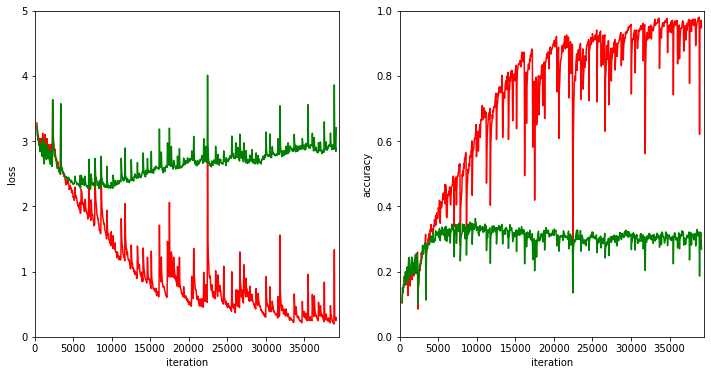

In [11]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,39500)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,39500)
acc_graph.set_ylim(0,1)

plt.show() 